In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
df = pd.read_csv("MoviesPlot.csv", usecols = ['Plot','imdbRating'])

In [3]:
df.head()

,Plot,imdbRating
0,"Story of Ned Kelly, an infamous 19th-century A...",6.0
1,Hamlet suspects his uncle has murdered his fat...,3.2
2,"A self-proclaimed ""knight"" and his hapless squ...",4.8
3,L. Frank Baum would appear in a white suit and...,5.2
4,The plumber Coupeau run into the lovable Gerva...,4.5


In [7]:
#df = df.dropna(subset=["description", "points"])

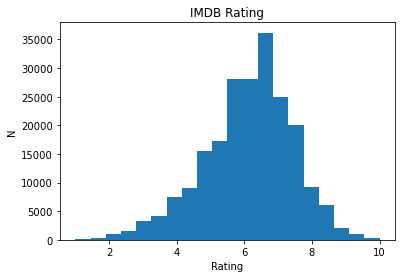

In [5]:
plt.hist(df.imdbRating, bins=20)
plt.title("IMDB Rating")
plt.ylabel("N")
plt.xlabel("Rating")
plt.show()

In [6]:
df["label"] = (df.imdbRating >= 7).astype(int)

In [7]:
df

,Plot,imdbRating,label
0,"Story of Ned Kelly, an infamous 19th-century A...",6.0,0
1,Hamlet suspects his uncle has murdered his fat...,3.2,0
2,"A self-proclaimed ""knight"" and his hapless squ...",4.8,0
3,L. Frank Baum would appear in a white suit and...,5.2,0
4,The plumber Coupeau run into the lovable Gerva...,4.5,0
...,...,...,...
215899,60-year-old Nils longs for an independent life...,6.5,0
215900,When a Japanese restaurant is extorted by the ...,3.6,0
215901,"Dj Steph is a young radio deejay on the rise, ...",5.8,0
215902,"Basque Country, 1609. The men of the region ar...",6.4,0


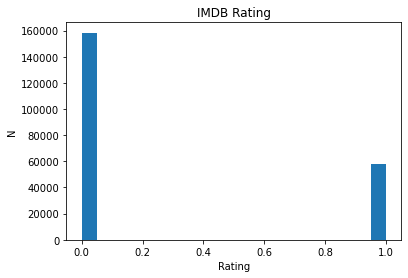

In [29]:
plt.hist(df.label, bins=20)
plt.title("IMDB Rating")
plt.ylabel("N")
plt.xlabel("Rating")
plt.show()

In [8]:
train, val, test = np.split(df.sample(frac=1), [int(0.7*len(df)), int(0.85*len(df))])

In [11]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  #dataframe now
  df = df["Plot"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [12]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# Pre-Trained Model Embedding

In [13]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [14]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.51636565,  0.08763389,  0.2562345 , ...,  0.02779502,
        -0.15499546,  0.08287886],
       [ 0.25367826, -0.06872955, -0.03970442, ...,  0.04139119,
         0.04548446, -0.05387019],
       [ 0.6390052 , -0.178707  ,  0.269199  , ...,  0.12674703,
        -0.17152116,  0.01662548],
       ...,
       [ 0.16088551,  0.28730434,  0.37230465, ..., -0.03463636,
         0.26081973, -0.18007232],
       [ 0.41302952,  0.03641953, -0.13648862, ..., -0.0477592 ,
         0.01905874,  0.01994701],
       [ 0.24376418,  0.09283273, -0.1879228 , ..., -0.15731306,
        -0.41595733, -0.07222372]], dtype=float32)>

In [15]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [17]:
model.evaluate(train_data)

148/148 [==============================] - 1s 6ms/step - loss: 0.6610 - accuracy: 0.7192


[0.6609598994255066, 0.7191792726516724]

In [18]:
model.evaluate(valid_data)

32/32 [==============================] - 0s 6ms/step - loss: 0.6609 - accuracy: 0.7215


[0.6608750820159912, 0.7214846014976501]

In [19]:
history = model.fit(train_data, epochs=7, validation_data=valid_data)

Epoch 1/7
148/148 [==============================] - 38s 253ms/step - loss: 0.5838 - accuracy: 0.7303 - val_loss: 0.5487 - val_accuracy: 0.7344
Epoch 2/7
148/148 [==============================] - 39s 266ms/step - loss: 0.5430 - accuracy: 0.7392 - val_loss: 0.5328 - val_accuracy: 0.7486
Epoch 3/7
148/148 [==============================] - 42s 282ms/step - loss: 0.5121 - accuracy: 0.7547 - val_loss: 0.5330 - val_accuracy: 0.7482
Epoch 4/7
148/148 [==============================] - 42s 281ms/step - loss: 0.4796 - accuracy: 0.7752 - val_loss: 0.5476 - val_accuracy: 0.7399
Epoch 5/7
148/148 [==============================] - 42s 283ms/step - loss: 0.4460 - accuracy: 0.7949 - val_loss: 0.5770 - val_accuracy: 0.7281
Epoch 6/7
148/148 [==============================] - 42s 284ms/step - loss: 0.4125 - accuracy: 0.8138 - val_loss: 0.6143 - val_accuracy: 0.7278
Epoch 7/7
148/148 [==============================] - 42s 287ms/step - loss: 0.3826 - accuracy: 0.8286 - val_loss: 0.6553 - val_accuracy:

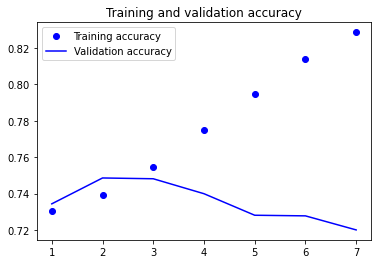

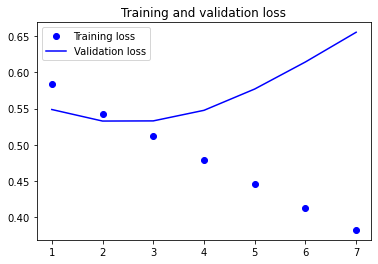

In [20]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
# It is observable that overfitting occurred after epoch 3.

In [21]:
model.evaluate(test_data)

32/32 [==============================] - 2s 48ms/step - loss: 0.6610 - accuracy: 0.7183


[0.6609737277030945, 0.7183042168617249]

# LTSM

In [22]:
# Max tokens: Number of words to remember
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [23]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'of', 'to', 'and', 'in', 'is', 'his',
       'with', 'her', 'an', 'he', 'for', 'on', 'who', 'by', 'their',
       'from'], dtype='<U13')

In [24]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [26]:
history = model.fit(train_data, epochs=7, validation_data=valid_data)

Epoch 1/7
148/148 [==============================] - 40s 254ms/step - loss: 0.5777 - accuracy: 0.7343 - val_loss: 0.5372 - val_accuracy: 0.7480
Epoch 2/7
148/148 [==============================] - 38s 260ms/step - loss: 0.5383 - accuracy: 0.7496 - val_loss: 0.5338 - val_accuracy: 0.7512
Epoch 3/7
148/148 [==============================] - 46s 302ms/step - loss: 0.5320 - accuracy: 0.7522 - val_loss: 0.5329 - val_accuracy: 0.7508
Epoch 4/7
148/148 [==============================] - 48s 323ms/step - loss: 0.5293 - accuracy: 0.7542 - val_loss: 0.5368 - val_accuracy: 0.7495
Epoch 5/7
148/148 [==============================] - 49s 329ms/step - loss: 0.5267 - accuracy: 0.7553 - val_loss: 0.5350 - val_accuracy: 0.7483
Epoch 6/7
148/148 [==============================] - 64s 434ms/step - loss: 0.5246 - accuracy: 0.7561 - val_loss: 0.5366 - val_accuracy: 0.7489
Epoch 7/7
148/148 [==============================] - 50s 334ms/step - loss: 0.5215 - accuracy: 0.7572 - val_loss: 0.5356 - val_accuracy:

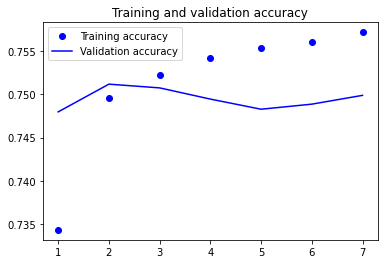

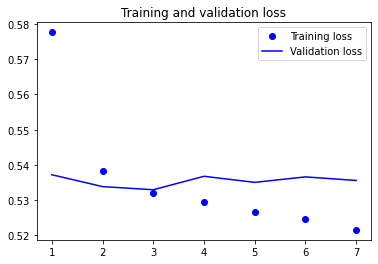

In [27]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [28]:
model.evaluate(test_data)

32/32 [==============================] - 3s 97ms/step - loss: 0.5366 - accuracy: 0.7484


[0.5366024374961853, 0.748440682888031]